In [1]:
# AI for Threat Detection - Python Examples
# Class 4: Hands-on Implementation

# ========================================
# CELL 1: Import Libraries
# ========================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.cluster import DBSCAN
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ All libraries imported successfully!")
print("📚 Ready to explore AI for Threat Detection")

✅ All libraries imported successfully!
📚 Ready to explore AI for Threat Detection


In [2]:
# ========================================
# CELL 2: Generate Synthetic Network Traffic Data
# ========================================

# Create synthetic network traffic data for demonstration
np.random.seed(42)

def generate_network_traffic(n_samples=1000, anomaly_fraction=0.05):
    """
    Generate synthetic network traffic data
    Features: packet_size, duration, src_bytes, dst_bytes, protocol_type
    """
    
    # Normal traffic patterns
    normal_samples = int(n_samples * (1 - anomaly_fraction))
    
    # Normal network behavior
    normal_data = {
        'packet_size': np.random.normal(512, 128, normal_samples),
        'duration': np.random.exponential(2, normal_samples),
        'src_bytes': np.random.normal(1024, 256, normal_samples),
        'dst_bytes': np.random.normal(2048, 512, normal_samples),
        'protocol_type': np.random.choice([0, 1, 2], normal_samples, p=[0.6, 0.3, 0.1])
    }
    
    # Anomalous traffic (potential attacks)
    anomaly_samples = n_samples - normal_samples
    anomaly_data = {
        'packet_size': np.random.normal(2048, 512, anomaly_samples),  # Larger packets
        'duration': np.random.exponential(10, anomaly_samples),       # Longer connections
        'src_bytes': np.random.normal(5120, 1024, anomaly_samples),   # More data sent
        'dst_bytes': np.random.normal(512, 128, anomaly_samples),     # Less data received
        'protocol_type': np.random.choice([0, 1, 2], anomaly_samples, p=[0.1, 0.1, 0.8])
    }
    
    # Combine normal and anomalous data
    data = {}
    labels = []
    
    for key in normal_data.keys():
        data[key] = np.concatenate([normal_data[key], anomaly_data[key]])
    
    labels = [0] * normal_samples + [1] * anomaly_samples  # 0 = normal, 1 = anomaly
    
    # Create DataFrame
    df = pd.DataFrame(data)
    df['label'] = labels
    
    # Shuffle the data
    df = df.sample(frac=1).reset_index(drop=True)
    
    return df

# Generate the dataset
network_data = generate_network_traffic(1000, 0.08)
print("📊 Generated synthetic network traffic data")
print(f"Dataset shape: {network_data.shape}")
print(f"Anomalies: {network_data['label'].sum()} ({network_data['label'].mean():.1%})")
print("\n🔍 First few rows:")
print(network_data.head())

📊 Generated synthetic network traffic data
Dataset shape: (1000, 6)
Anomalies: 80 (8.0%)

🔍 First few rows:
   packet_size  duration    src_bytes    dst_bytes  protocol_type  label
0   590.839758  4.132228   924.902476  1672.624027              0      0
1   535.467777  1.102387   828.742457  1814.763763              0      0
2   541.728473  1.242111   831.447960  2060.238358              0      0
3   412.439464  1.575034  1251.239789  2028.022006              0      0
4   581.550105  2.100794   866.211480  2978.847704              1      0


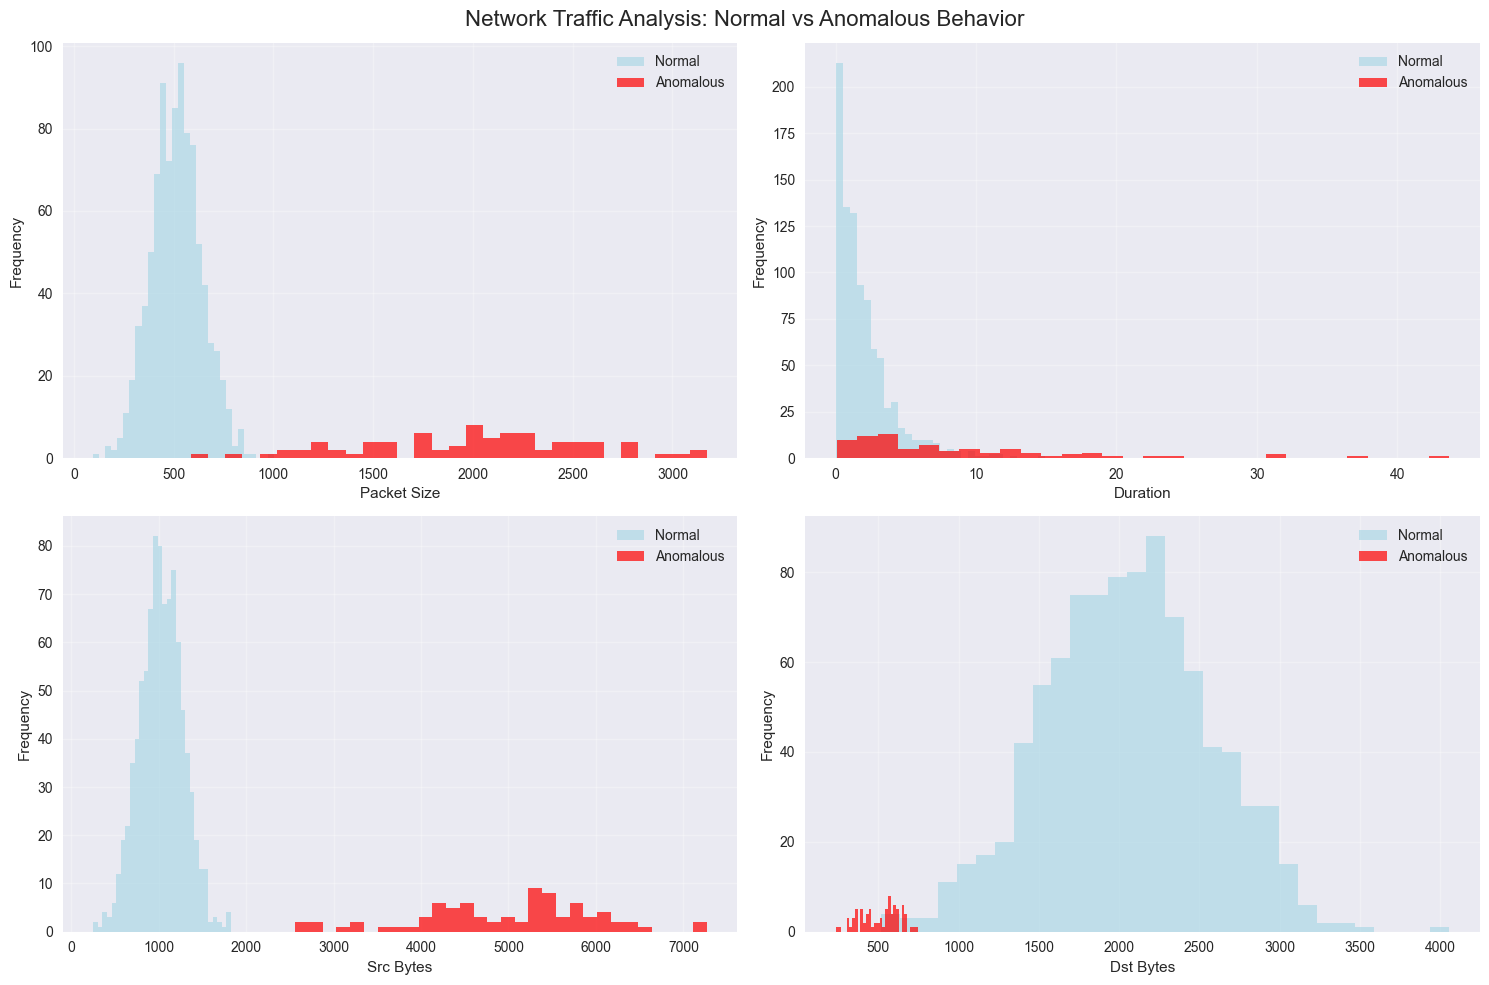

📈 Key Observations:
• Normal traffic shows consistent patterns
• Anomalous traffic has different distributions
• This is what anomaly detection algorithms will learn to identify


In [3]:
# ========================================
# CELL 3: Exploratory Data Analysis
# ========================================

# Visualize the data to understand normal vs anomalous patterns
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Network Traffic Analysis: Normal vs Anomalous Behavior', fontsize=16)

features = ['packet_size', 'duration', 'src_bytes', 'dst_bytes']

for i, feature in enumerate(features):
    ax = axes[i//2, i%2]
    
    # Plot normal traffic
    normal_data = network_data[network_data['label'] == 0][feature]
    anomaly_data = network_data[network_data['label'] == 1][feature]
    
    ax.hist(normal_data, bins=30, alpha=0.7, label='Normal', color='lightblue')
    ax.hist(anomaly_data, bins=30, alpha=0.7, label='Anomalous', color='red')
    
    ax.set_xlabel(feature.replace('_', ' ').title())
    ax.set_ylabel('Frequency')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("📈 Key Observations:")
print("• Normal traffic shows consistent patterns")
print("• Anomalous traffic has different distributions")
print("• This is what anomaly detection algorithms will learn to identify")

🔍 ANOMALY DETECTION EXAMPLE 1: Isolation Forest
🎯 Isolation Forest Results:
   Accuracy:  0.980
   Precision: 0.800
   Recall:    1.000
   F1-Score:  0.889


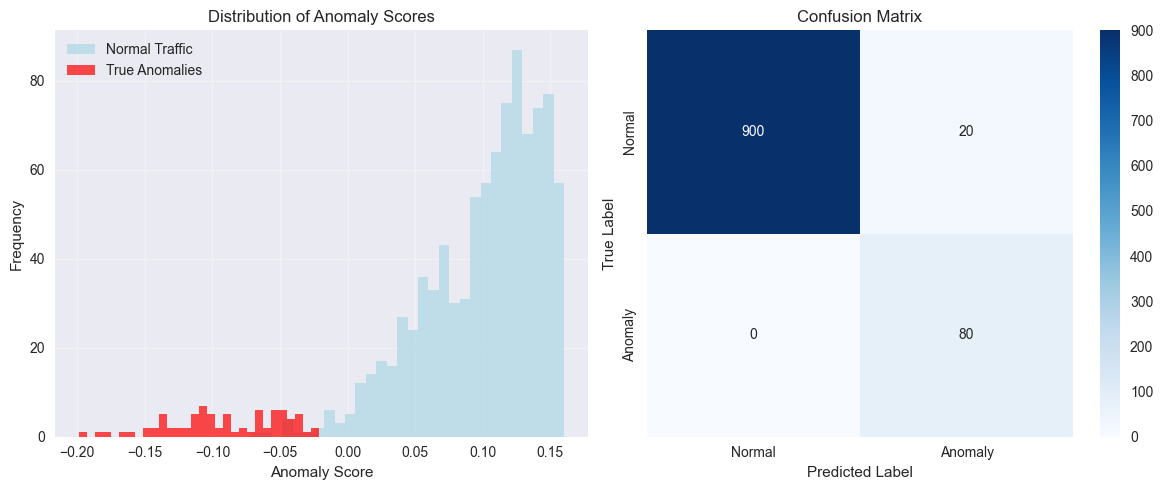


💡 Key Insight: Isolation Forest isolates anomalies by randomly selecting features
   and split values. Anomalies are easier to isolate (fewer splits needed).


In [4]:
# ========================================
# CELL 4: Anomaly Detection - Isolation Forest
# ========================================

print("🔍 ANOMALY DETECTION EXAMPLE 1: Isolation Forest")
print("="*60)

# Prepare features for anomaly detection
feature_cols = ['packet_size', 'duration', 'src_bytes', 'dst_bytes', 'protocol_type']
X = network_data[feature_cols]
y_true = network_data['label']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply Isolation Forest (unsupervised anomaly detection)
iso_forest = IsolationForest(
    contamination=0.1,  # Expected proportion of anomalies
    random_state=42,
    n_estimators=100
)

# Fit and predict
anomaly_scores = iso_forest.fit_predict(X_scaled)
anomaly_scores_binary = (anomaly_scores == -1).astype(int)  # Convert to 0/1

# Evaluate performance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_true, anomaly_scores_binary)
precision = precision_score(y_true, anomaly_scores_binary)
recall = recall_score(y_true, anomaly_scores_binary)
f1 = f1_score(y_true, anomaly_scores_binary)

print(f"🎯 Isolation Forest Results:")
print(f"   Accuracy:  {accuracy:.3f}")
print(f"   Precision: {precision:.3f}")
print(f"   Recall:    {recall:.3f}")
print(f"   F1-Score:  {f1:.3f}")

# Visualize results
plt.figure(figsize=(12, 5))

# Plot 1: Anomaly scores
plt.subplot(1, 2, 1)
normal_scores = iso_forest.decision_function(X_scaled)[y_true == 0]
anomaly_scores_true = iso_forest.decision_function(X_scaled)[y_true == 1]

plt.hist(normal_scores, bins=30, alpha=0.7, label='Normal Traffic', color='lightblue')
plt.hist(anomaly_scores_true, bins=30, alpha=0.7, label='True Anomalies', color='red')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.title('Distribution of Anomaly Scores')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Confusion Matrix
plt.subplot(1, 2, 2)
cm = confusion_matrix(y_true, anomaly_scores_binary)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Anomaly'], 
            yticklabels=['Normal', 'Anomaly'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.tight_layout()
plt.show()

print("\n💡 Key Insight: Isolation Forest isolates anomalies by randomly selecting features")
print("   and split values. Anomalies are easier to isolate (fewer splits needed).")

In [5]:
# ========================================
# CELL 5: Anomaly Detection - One-Class SVM
# ========================================

print("\n🔍 ANOMALY DETECTION EXAMPLE 2: One-Class SVM")
print("="*60)

# Apply One-Class SVM
oc_svm = OneClassSVM(
    kernel='rbf',
    gamma='scale',
    nu=0.1  # Expected proportion of anomalies
)

# Fit on normal data only (unsupervised approach)
normal_data_indices = y_true == 0
X_normal = X_scaled[normal_data_indices]
oc_svm.fit(X_normal)

# Predict on all data
svm_predictions = oc_svm.predict(X_scaled)
svm_predictions_binary = (svm_predictions == -1).astype(int)

# Evaluate performance
svm_accuracy = accuracy_score(y_true, svm_predictions_binary)
svm_precision = precision_score(y_true, svm_predictions_binary)
svm_recall = recall_score(y_true, svm_predictions_binary)
svm_f1 = f1_score(y_true, svm_predictions_binary)

print(f"🎯 One-Class SVM Results:")
print(f"   Accuracy:  {svm_accuracy:.3f}")
print(f"   Precision: {svm_precision:.3f}")
print(f"   Recall:    {svm_recall:.3f}")
print(f"   F1-Score:  {svm_f1:.3f}")

print("\n📊 Comparison:")
print(f"{'Method':<15} {'Accuracy':<10} {'Precision':<12} {'Recall':<10} {'F1-Score':<10}")
print("-" * 60)
print(f"{'Isolation Forest':<15} {accuracy:<10.3f} {precision:<12.3f} {recall:<10.3f} {f1:<10.3f}")
print(f"{'One-Class SVM':<15} {svm_accuracy:<10.3f} {svm_precision:<12.3f} {svm_recall:<10.3f} {svm_f1:<10.3f}")

print("\n💡 Key Insight: One-Class SVM learns a boundary around normal data.")
print("   Points outside this boundary are considered anomalies.")


🔍 ANOMALY DETECTION EXAMPLE 2: One-Class SVM
🎯 One-Class SVM Results:
   Accuracy:  0.904
   Precision: 0.455
   Recall:    1.000
   F1-Score:  0.625

📊 Comparison:
Method          Accuracy   Precision    Recall     F1-Score  
------------------------------------------------------------
Isolation Forest 0.980      0.800        1.000      0.889     
One-Class SVM   0.904      0.455        1.000      0.625     

💡 Key Insight: One-Class SVM learns a boundary around normal data.
   Points outside this boundary are considered anomalies.



🛡️  INTRUSION DETECTION SYSTEM SIMULATION
🔍 IDS Dataset Overview:
Total samples: 1000

📊 Attack Type Distribution:
attack_type
normal    720
dos       107
probe      82
r2l        54
u2r        37
Name: count, dtype: int64


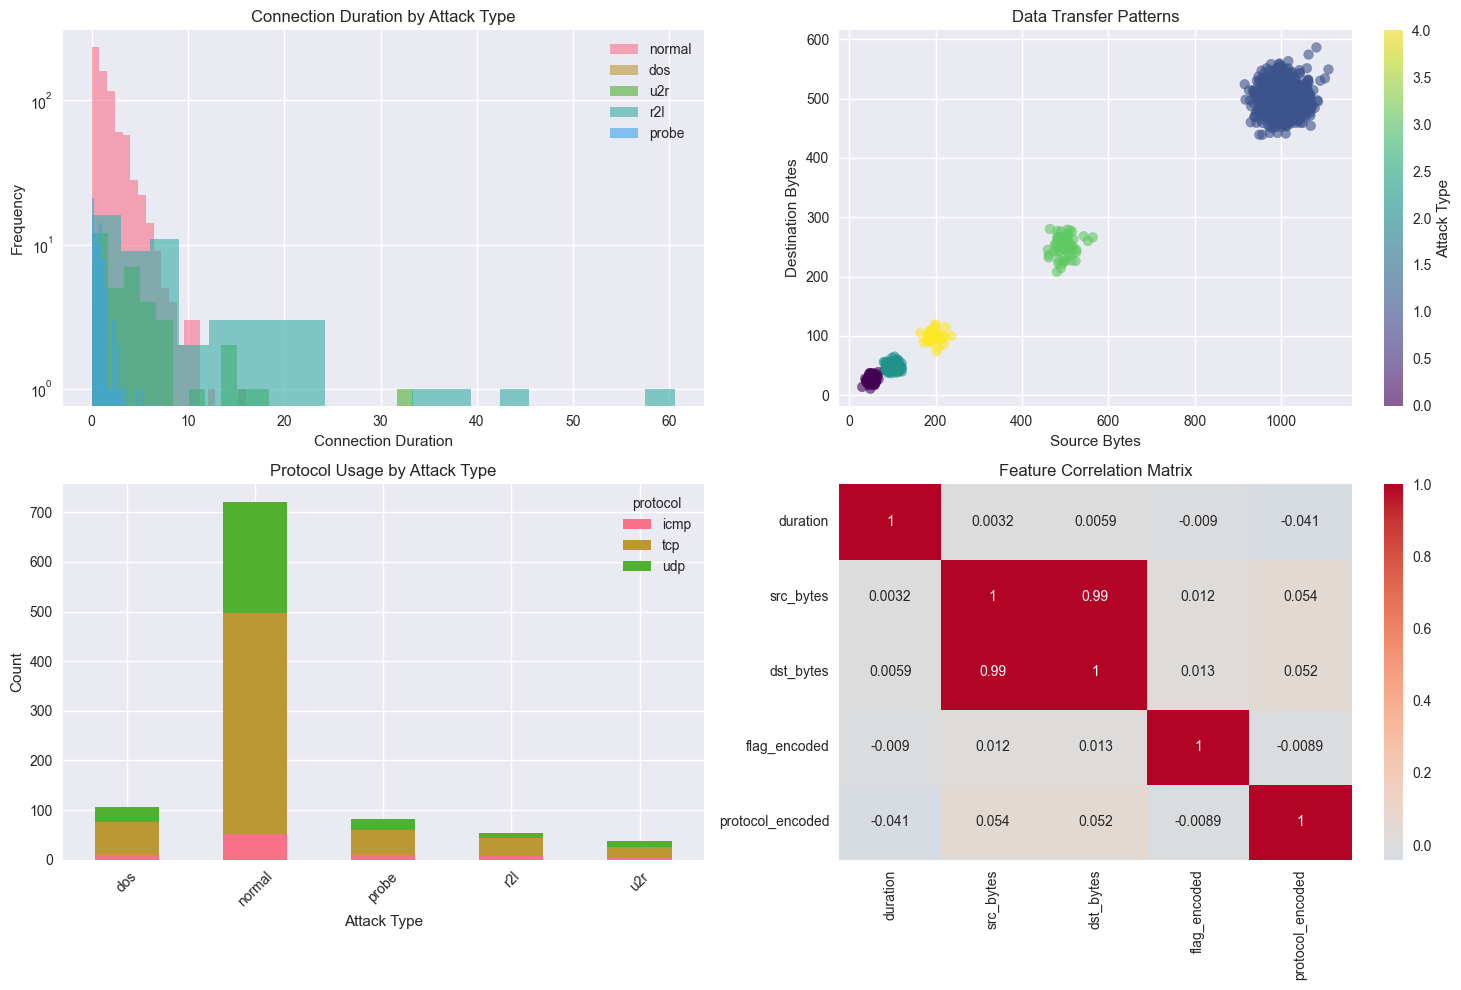


💡 IDS Insights:
• Different attack types show distinct behavioral patterns
• DoS attacks: Short duration, low bytes
• Probe attacks: Moderate duration, low bytes
• Normal traffic: Longer duration, higher bytes


In [6]:
# ========================================
# CELL 6: Intrusion Detection System Simulation
# ========================================

print("\n🛡️  INTRUSION DETECTION SYSTEM SIMULATION")
print("="*60)

def generate_network_logs(n_samples=500):
    """Generate synthetic network logs with different attack types"""
    
    # Define attack patterns
    attack_types = {
        'normal': {'prob': 0.7, 'duration_mean': 2, 'bytes_mean': 1000},
        'dos': {'prob': 0.1, 'duration_mean': 0.1, 'bytes_mean': 50},      # Denial of Service
        'probe': {'prob': 0.1, 'duration_mean': 1, 'bytes_mean': 100},     # Port scanning
        'r2l': {'prob': 0.05, 'duration_mean': 10, 'bytes_mean': 500},     # Remote to Local
        'u2r': {'prob': 0.05, 'duration_mean': 5, 'bytes_mean': 200}       # User to Root
    }
    
    logs = []
    
    for _ in range(n_samples):
        # Randomly select attack type based on probabilities
        attack = np.random.choice(
            list(attack_types.keys()),
            p=[attack_types[k]['prob'] for k in attack_types.keys()]
        )
        
        # Generate features based on attack type
        duration = np.random.exponential(attack_types[attack]['duration_mean'])
        src_bytes = np.random.poisson(attack_types[attack]['bytes_mean'])
        dst_bytes = np.random.poisson(attack_types[attack]['bytes_mean'] * 0.5)
        
        # Add some noise and additional features
        flag = np.random.choice(['SF', 'S0', 'REJ', 'RSTR'], p=[0.7, 0.1, 0.1, 0.1])
        protocol = np.random.choice(['tcp', 'udp', 'icmp'], p=[0.6, 0.3, 0.1])
        
        logs.append({
            'duration': duration,
            'src_bytes': src_bytes,
            'dst_bytes': dst_bytes,
            'flag': flag,
            'protocol': protocol,
            'attack_type': attack
        })
    
    return pd.DataFrame(logs)

# Generate IDS dataset
ids_data = generate_network_logs(1000)

# Encode categorical variables
from sklearn.preprocessing import LabelEncoder

le_flag = LabelEncoder()
le_protocol = LabelEncoder()

ids_data['flag_encoded'] = le_flag.fit_transform(ids_data['flag'])
ids_data['protocol_encoded'] = le_protocol.fit_transform(ids_data['protocol'])

print("🔍 IDS Dataset Overview:")
print(f"Total samples: {len(ids_data)}")
print("\n📊 Attack Type Distribution:")
print(ids_data['attack_type'].value_counts())

# Visualize attack patterns
plt.figure(figsize=(15, 10))

# Plot 1: Duration by attack type
plt.subplot(2, 2, 1)
for attack in ids_data['attack_type'].unique():
    data = ids_data[ids_data['attack_type'] == attack]['duration']
    plt.hist(data, bins=20, alpha=0.6, label=attack)
plt.xlabel('Connection Duration')
plt.ylabel('Frequency')
plt.title('Connection Duration by Attack Type')
plt.legend()
plt.yscale('log')

# Plot 2: Bytes transferred
plt.subplot(2, 2, 2)
plt.scatter(ids_data['src_bytes'], ids_data['dst_bytes'], 
           c=pd.Categorical(ids_data['attack_type']).codes, 
           alpha=0.6, cmap='viridis')
plt.xlabel('Source Bytes')
plt.ylabel('Destination Bytes')
plt.title('Data Transfer Patterns')
plt.colorbar(label='Attack Type')

# Plot 3: Protocol distribution
plt.subplot(2, 2, 3)
attack_protocol = pd.crosstab(ids_data['attack_type'], ids_data['protocol'])
attack_protocol.plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Protocol Usage by Attack Type')
plt.xlabel('Attack Type')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Plot 4: Feature correlation
plt.subplot(2, 2, 4)
numeric_features = ['duration', 'src_bytes', 'dst_bytes', 'flag_encoded', 'protocol_encoded']
correlation_matrix = ids_data[numeric_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')

plt.tight_layout()
plt.show()

print("\n💡 IDS Insights:")
print("• Different attack types show distinct behavioral patterns")
print("• DoS attacks: Short duration, low bytes")
print("• Probe attacks: Moderate duration, low bytes") 
print("• Normal traffic: Longer duration, higher bytes")


🤖 AI-ENHANCED IDS: MULTI-CLASS CLASSIFICATION
🎯 AI-Enhanced IDS Results:

Classification Report:
              precision    recall  f1-score   support

         dos       1.00      1.00      1.00        32
      normal       1.00      1.00      1.00       216
       probe       1.00      1.00      1.00        25
         r2l       1.00      1.00      1.00        16
         u2r       1.00      1.00      1.00        11

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



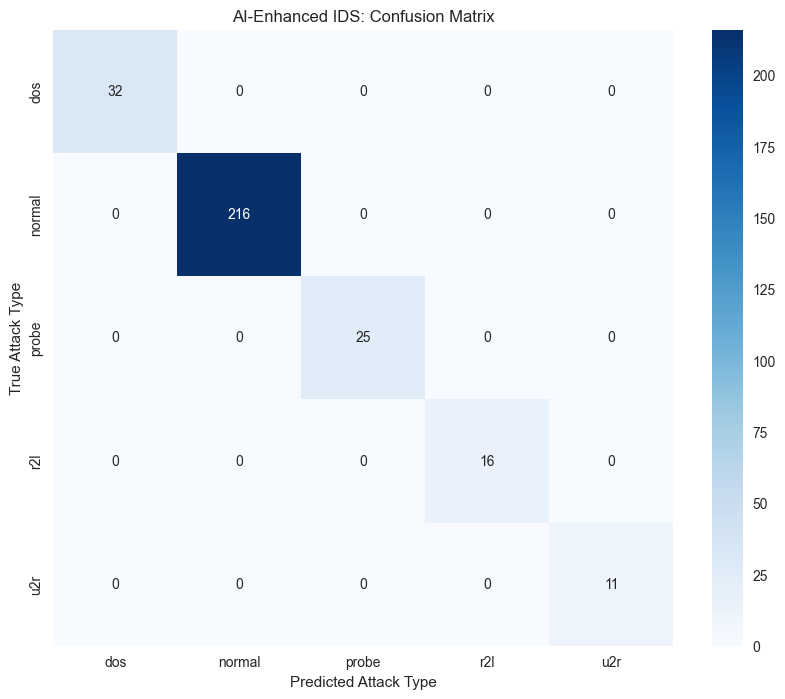

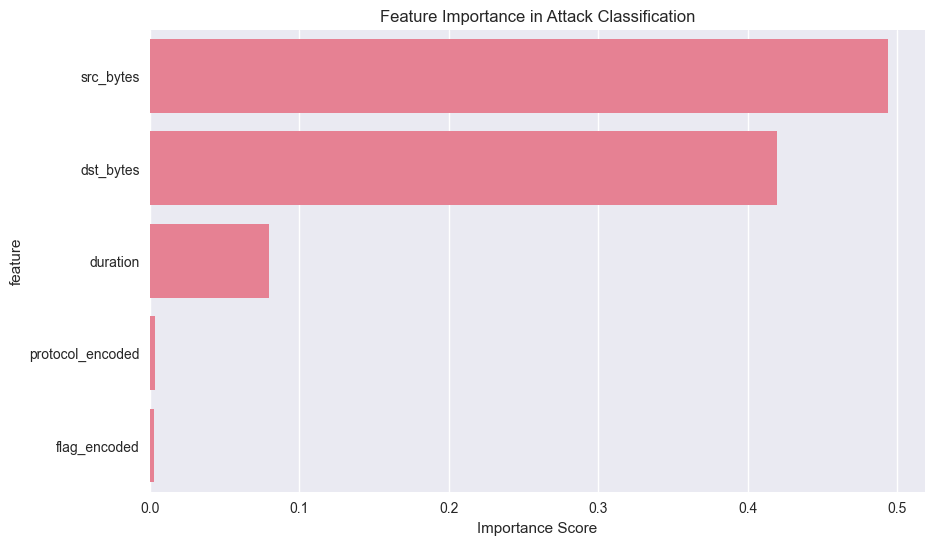


📊 Most Important Features:
   src_bytes: 0.494
   dst_bytes: 0.420
   duration: 0.080
   protocol_encoded: 0.004
   flag_encoded: 0.003

💡 Key Insight: AI can distinguish between different attack types
   based on behavioral patterns in network traffic.


In [7]:
# ========================================
# CELL 7: AI-Enhanced IDS Classification
# ========================================

print("\n🤖 AI-ENHANCED IDS: MULTI-CLASS CLASSIFICATION")
print("="*60)

# Prepare data for classification
feature_columns = ['duration', 'src_bytes', 'dst_bytes', 'flag_encoded', 'protocol_encoded']
X_ids = ids_data[feature_columns]
y_ids = ids_data['attack_type']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_ids, y_ids, test_size=0.3, random_state=42, stratify=y_ids)

# Scale features
scaler_ids = StandardScaler()
X_train_scaled = scaler_ids.fit_transform(X_train)
X_test_scaled = scaler_ids.transform(X_test)

# Train Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
rf_classifier.fit(X_train_scaled, y_train)

# Make predictions
y_pred = rf_classifier.predict(X_test_scaled)

# Evaluate performance
print("🎯 AI-Enhanced IDS Results:")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred, labels=rf_classifier.classes_)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=rf_classifier.classes_, 
            yticklabels=rf_classifier.classes_)
plt.title('AI-Enhanced IDS: Confusion Matrix')
plt.ylabel('True Attack Type')
plt.xlabel('Predicted Attack Type')
plt.show()

# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_classifier.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Feature Importance in Attack Classification')
plt.xlabel('Importance Score')
plt.show()

print("\n📊 Most Important Features:")
for i, row in feature_importance.iterrows():
    print(f"   {row['feature']}: {row['importance']:.3f}")

print("\n💡 Key Insight: AI can distinguish between different attack types")
print("   based on behavioral patterns in network traffic.")


🦠 MALWARE DETECTION: STATIC ANALYSIS SIMULATION
🔍 Malware Dataset Overview:
Total samples: 1000
Malware samples: 250 (25.0%)
Benign samples: 750 (75.0%)


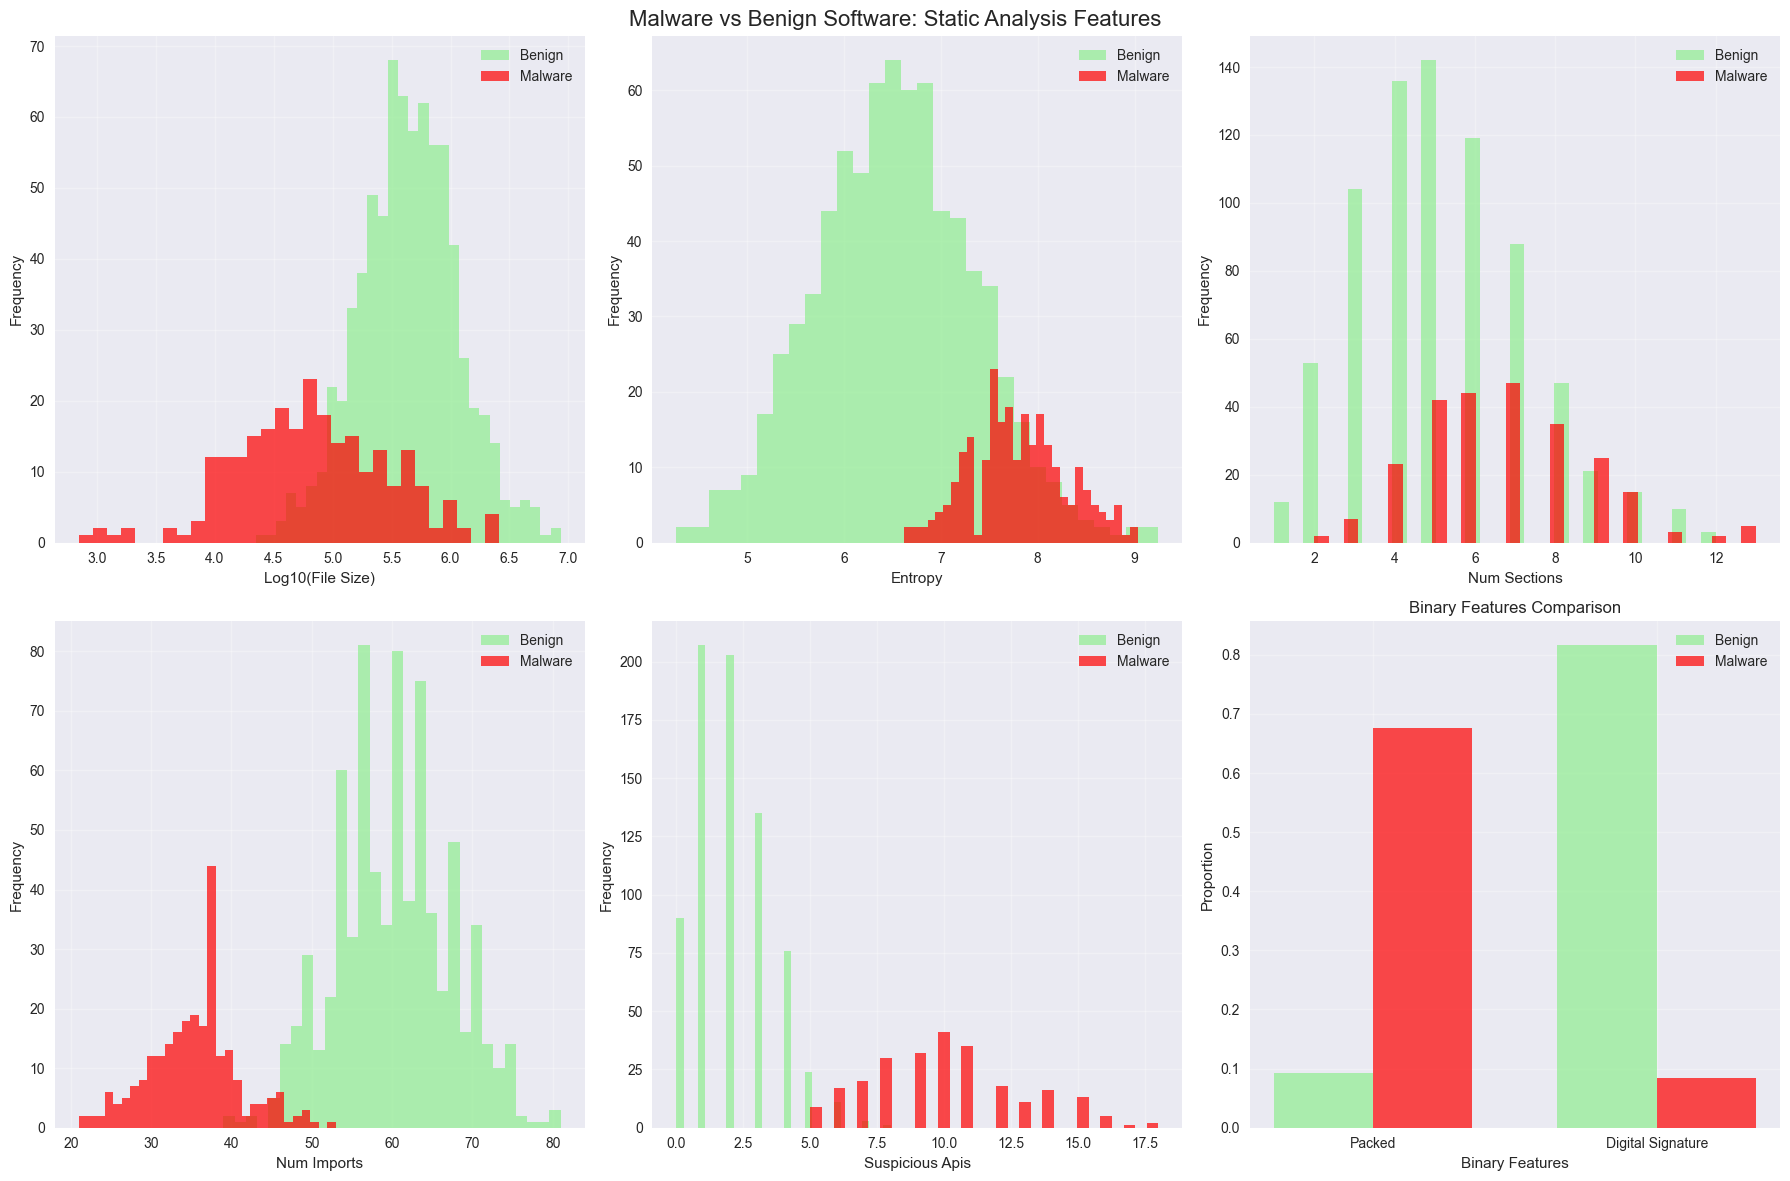


📊 Key Observations:
• Malware often has higher entropy (indicates packing/encryption)
• Malware typically has more suspicious API calls
• Benign software more likely to be digitally signed
• File size distributions differ between malware and benign


In [8]:
# ========================================
# CELL 8: Malware Detection - Static Analysis Features
# ========================================

print("\n🦠 MALWARE DETECTION: STATIC ANALYSIS SIMULATION")
print("="*60)

def generate_pe_features(n_samples=800, malware_ratio=0.3):
    """Generate synthetic PE file features for malware detection"""
    
    n_malware = int(n_samples * malware_ratio)
    n_benign = n_samples - n_malware
    
    # Benign software characteristics
    benign_features = {
        'file_size': np.random.lognormal(mean=13, sigma=1, size=n_benign),  # ~450KB average
        'entropy': np.random.normal(6.5, 0.8, n_benign),  # Lower entropy
        'num_sections': np.random.poisson(4, n_benign) + 1,  # Typical sections
        'num_imports': np.random.poisson(50, n_benign) + 10,  # Normal imports
        'suspicious_apis': np.random.poisson(2, n_benign),  # Few suspicious APIs
        'packed': np.random.choice([0, 1], n_benign, p=[0.9, 0.1]),  # Rarely packed
        'digital_signature': np.random.choice([0, 1], n_benign, p=[0.2, 0.8])  # Often signed
    }
    
    # Malware characteristics
    malware_features = {
        'file_size': np.random.lognormal(mean=11, sigma=1.5, size=n_malware),  # Smaller/varied
        'entropy': np.random.normal(7.8, 0.5, n_malware),  # Higher entropy (packed/encrypted)
        'num_sections': np.random.poisson(6, n_malware) + 1,  # More sections  
        'num_imports': np.random.poisson(30, n_malware) + 5,  # Fewer/hidden imports
        'suspicious_apis': np.random.poisson(8, n_malware) + 2,  # Many suspicious APIs
        'packed': np.random.choice([0, 1], n_malware, p=[0.3, 0.7]),  # Often packed
        'digital_signature': np.random.choice([0, 1], n_malware, p=[0.9, 0.1])  # Rarely signed
    }
    
    # Combine data
    features_data = {}
    labels = []
    
    for key in benign_features.keys():
        features_data[key] = np.concatenate([benign_features[key], malware_features[key]])
    
    labels = [0] * n_benign + [1] * n_malware  # 0 = benign, 1 = malware
    
    # Create DataFrame
    df = pd.DataFrame(features_data)
    df['is_malware'] = labels
    
    # Shuffle
    df = df.sample(frac=1).reset_index(drop=True)
    
    return df

# Generate malware dataset
malware_data = generate_pe_features(1000, 0.25)

print("🔍 Malware Dataset Overview:")
print(f"Total samples: {len(malware_data)}")
print(f"Malware samples: {malware_data['is_malware'].sum()} ({malware_data['is_malware'].mean():.1%})")
print(f"Benign samples: {(1-malware_data['is_malware']).sum()} ({(1-malware_data['is_malware']).mean():.1%})")

# Visualize malware vs benign characteristics
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Malware vs Benign Software: Static Analysis Features', fontsize=16)

features_to_plot = ['file_size', 'entropy', 'num_sections', 'num_imports', 'suspicious_apis']

for i, feature in enumerate(features_to_plot):
    ax = axes[i//3, i%3]
    
    benign_data = malware_data[malware_data['is_malware'] == 0][feature]
    malware_data_feature = malware_data[malware_data['is_malware'] == 1][feature]
    
    if feature == 'file_size':
        # Use log scale for file size
        ax.hist(np.log10(benign_data), bins=30, alpha=0.7, label='Benign', color='lightgreen')
        ax.hist(np.log10(malware_data_feature), bins=30, alpha=0.7, label='Malware', color='red')
        ax.set_xlabel('Log10(File Size)')
    else:
        ax.hist(benign_data, bins=30, alpha=0.7, label='Benign', color='lightgreen')
        ax.hist(malware_data_feature, bins=30, alpha=0.7, label='Malware', color='red')
        ax.set_xlabel(feature.replace('_', ' ').title())
    
    ax.set_ylabel('Frequency')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Add categorical features plot
ax = axes[1, 2]
categories = ['packed', 'digital_signature']
x_pos = np.arange(len(categories))

benign_means = [malware_data[malware_data['is_malware'] == 0][cat].mean() for cat in categories]
malware_means = [malware_data[malware_data['is_malware'] == 1][cat].mean() for cat in categories]

width = 0.35
ax.bar(x_pos - width/2, benign_means, width, label='Benign', color='lightgreen', alpha=0.7)
ax.bar(x_pos + width/2, malware_means, width, label='Malware', color='red', alpha=0.7)

ax.set_xlabel('Binary Features')
ax.set_ylabel('Proportion')
ax.set_title('Binary Features Comparison')
ax.set_xticks(x_pos)
ax.set_xticklabels([cat.replace('_', ' ').title() for cat in categories])
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Key Observations:")
print("• Malware often has higher entropy (indicates packing/encryption)")
print("• Malware typically has more suspicious API calls")
print("• Benign software more likely to be digitally signed")
print("• File size distributions differ between malware and benign")


🤖 AI-POWERED MALWARE CLASSIFICATION
🎯 Malware Classification Results:

Classification Report:
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00       225
     Malware       1.00      1.00      1.00        75

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



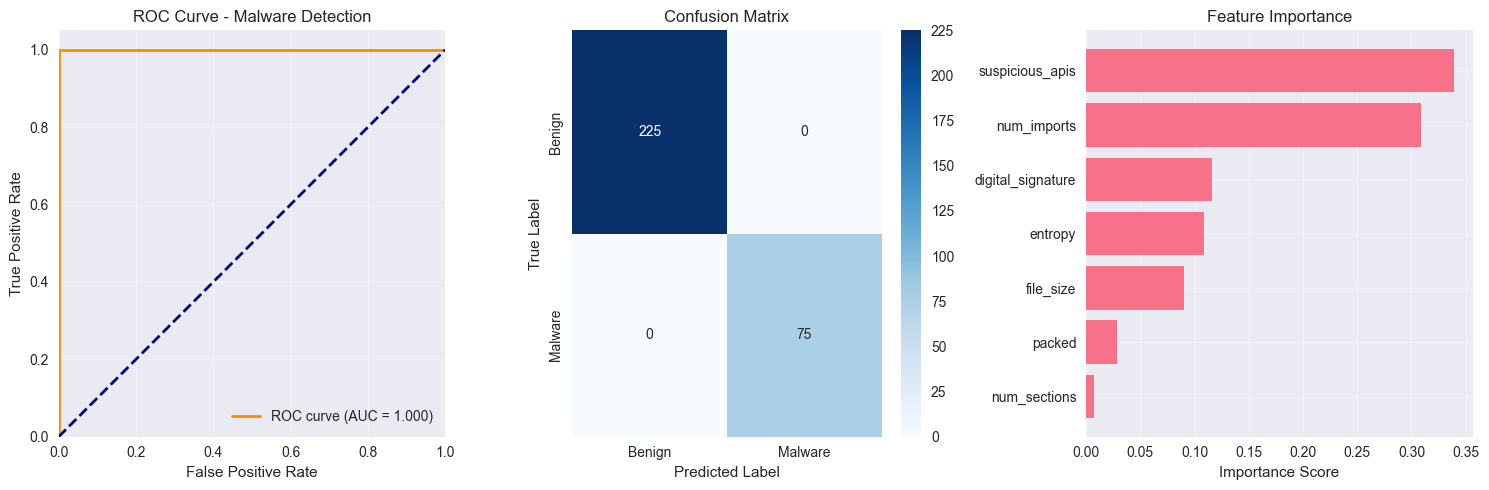


📊 Feature Importance Ranking:
   suspicious_apis     : 0.339
   num_imports         : 0.309
   digital_signature   : 0.116
   entropy             : 0.109
   file_size           : 0.090
   packed              : 0.029
   num_sections        : 0.008

🎯 Model Performance Summary:
   ROC AUC Score: 1.000
   Accuracy: 1.000


In [9]:
# ========================================
# CELL 9: Malware Classification with AI
# ========================================

print("\n🤖 AI-POWERED MALWARE CLASSIFICATION")
print("="*60)

# Prepare features for classification
feature_cols_malware = ['file_size', 'entropy', 'num_sections', 'num_imports', 
                       'suspicious_apis', 'packed', 'digital_signature']
X_malware = malware_data[feature_cols_malware]
y_malware = malware_data['is_malware']

# Split the data
X_train_mal, X_test_mal, y_train_mal, y_test_mal = train_test_split(
    X_malware, y_malware, test_size=0.3, random_state=42, stratify=y_malware
)

# Scale features
scaler_malware = StandardScaler()
X_train_mal_scaled = scaler_malware.fit_transform(X_train_mal)
X_test_mal_scaled = scaler_malware.transform(X_test_mal)

# Train Random Forest for malware detection
rf_malware = RandomForestClassifier(n_estimators=150, random_state=42, max_depth=15)
rf_malware.fit(X_train_mal_scaled, y_train_mal)

# Make predictions
y_pred_mal = rf_malware.predict(X_test_mal_scaled)
y_pred_proba_mal = rf_malware.predict_proba(X_test_mal_scaled)[:, 1]

# Evaluate performance
print("🎯 Malware Classification Results:")
print("\nClassification Report:")
print(classification_report(y_test_mal, y_pred_mal, target_names=['Benign', 'Malware']))

# ROC Curve
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test_mal, y_pred_proba_mal)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(15, 5))

# Plot 1: ROC Curve
plt.subplot(1, 3, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Malware Detection')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

# Plot 2: Confusion Matrix
plt.subplot(1, 3, 2)
cm_mal = confusion_matrix(y_test_mal, y_pred_mal)
sns.heatmap(cm_mal, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Benign', 'Malware'], 
            yticklabels=['Benign', 'Malware'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Plot 3: Feature Importance
plt.subplot(1, 3, 3)
feature_importance_mal = pd.DataFrame({
    'feature': feature_cols_malware,
    'importance': rf_malware.feature_importances_
}).sort_values('importance', ascending=True)

plt.barh(range(len(feature_importance_mal)), feature_importance_mal['importance'])
plt.yticks(range(len(feature_importance_mal)), feature_importance_mal['feature'])
plt.xlabel('Importance Score')
plt.title('Feature Importance')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Detailed feature importance
print("\n📊 Feature Importance Ranking:")
for i, row in feature_importance_mal.sort_values('importance', ascending=False).iterrows():
    print(f"   {row['feature']:<20}: {row['importance']:.3f}")

print(f"\n🎯 Model Performance Summary:")
print(f"   ROC AUC Score: {roc_auc:.3f}")
print(f"   Accuracy: {rf_malware.score(X_test_mal_scaled, y_test_mal):.3f}")


🧬 ADVANCED EXAMPLE: BEHAVIORAL CLUSTERING FOR THREAT DETECTION
🔍 User Behavior Dataset:
Total records: 4500
Unique users: 150
Days tracked: 30

📊 User Type Distribution:
user_type
normal_employee      2640
power_user            900
admin                 510
malicious_insider     450
Name: count, dtype: int64

🧬 Behavioral Clustering Results:
Number of clusters found: 4
Outliers (anomalous users): 17

📊 Cluster Analysis:

🚨 Outliers (Cluster -1):
   Count: 17
   User types: {np.str_('malicious_insider'): 15, np.str_('power_user'): 1, np.str_('admin'): 1}

🚨 Outliers (Cluster -1):
   Count: 17
   User types: {np.str_('malicious_insider'): 15, np.str_('power_user'): 1, np.str_('admin'): 1}

🚨 Outliers (Cluster -1):
   Count: 17
   User types: {np.str_('malicious_insider'): 15, np.str_('power_user'): 1, np.str_('admin'): 1}

🚨 Outliers (Cluster -1):
   Count: 17
   User types: {np.str_('malicious_insider'): 15, np.str_('power_user'): 1, np.str_('admin'): 1}

🚨 Outliers (Cluster -1):
   Co

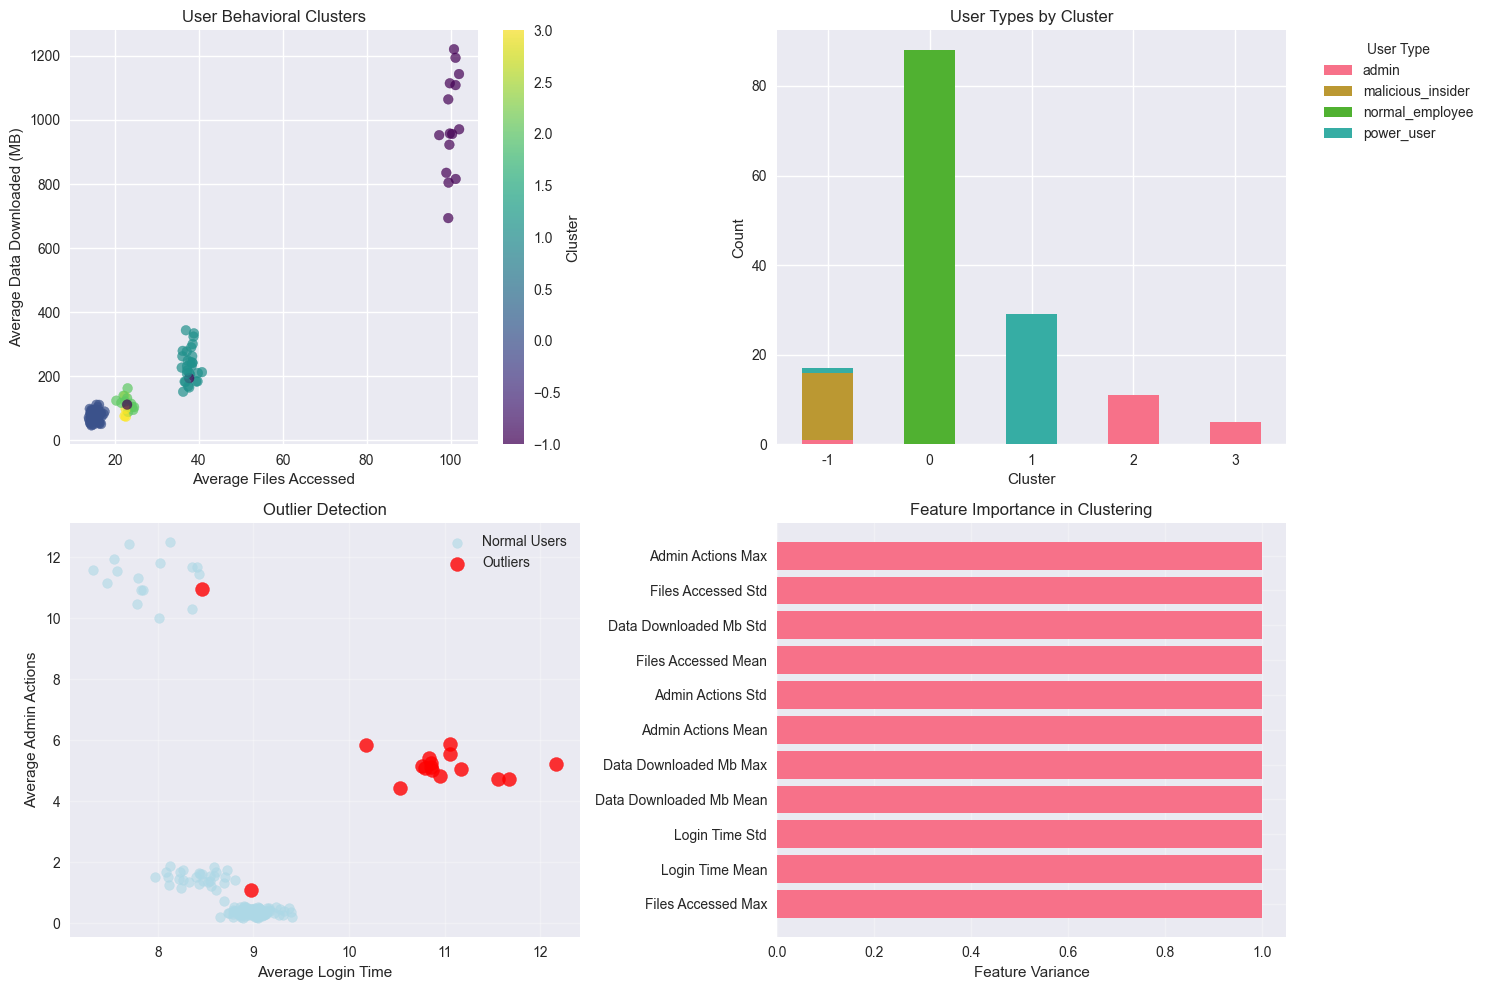


💡 Key Insights from Behavioral Clustering:
• Clustering can identify users with unusual behavior patterns
• Outliers often correspond to malicious insiders or compromised accounts
• Normal user types cluster together based on similar behavior
• This approach can detect insider threats that traditional methods miss


In [10]:
# ========================================
# CELL 10: Advanced Example - Behavioral Clustering
# ========================================

print("\n🧬 ADVANCED EXAMPLE: BEHAVIORAL CLUSTERING FOR THREAT DETECTION")
print("="*60)

def generate_user_behavior_data(n_users=200, n_days=30):
    """Generate synthetic user behavior data over time"""
    
    behavior_data = []
    user_types = ['normal_employee', 'power_user', 'admin', 'malicious_insider']
    
    for user_id in range(n_users):
        # Assign user type
        user_type = np.random.choice(user_types, p=[0.7, 0.15, 0.1, 0.05])
        
        for day in range(n_days):
            if user_type == 'normal_employee':
                login_time = np.random.normal(9, 1)  # 9 AM ± 1 hour
                files_accessed = np.random.poisson(20)
                data_downloaded = np.random.exponential(100)  # MB
                admin_actions = np.random.poisson(0.5)
                
            elif user_type == 'power_user':
                login_time = np.random.normal(8.5, 1.5)
                files_accessed = np.random.poisson(50)
                data_downloaded = np.random.exponential(300)
                admin_actions = np.random.poisson(2)
                
            elif user_type == 'admin':
                login_time = np.random.normal(8, 2)
                files_accessed = np.random.poisson(30)
                data_downloaded = np.random.exponential(150)
                admin_actions = np.random.poisson(15)
                
            else:  # malicious_insider
                login_time = np.random.normal(11, 3)  # Irregular hours
                files_accessed = np.random.poisson(100)  # Excessive access
                data_downloaded = np.random.exponential(1000)  # Large downloads
                admin_actions = np.random.poisson(5)
            
            # Add weekend behavior (different patterns)
            if day % 7 in [5, 6]:  # Weekend
                if user_type != 'malicious_insider':
                    files_accessed *= 0.1  # Much lower activity
                    data_downloaded *= 0.1
                    admin_actions *= 0.1
            
            behavior_data.append({
                'user_id': user_id,
                'day': day,
                'user_type': user_type,
                'login_time': max(0, min(24, login_time)),
                'files_accessed': max(0, files_accessed),
                'data_downloaded_mb': max(0, data_downloaded),
                'admin_actions': max(0, admin_actions),
                'is_weekend': 1 if day % 7 in [5, 6] else 0
            })
    
    return pd.DataFrame(behavior_data)

# Generate behavioral data
behavior_df = generate_user_behavior_data(150, 30)

print("🔍 User Behavior Dataset:")
print(f"Total records: {len(behavior_df)}")
print(f"Unique users: {behavior_df['user_id'].nunique()}")
print(f"Days tracked: {behavior_df['day'].nunique()}")
print("\n📊 User Type Distribution:")
print(behavior_df['user_type'].value_counts())

# Aggregate user behavior over time
user_profiles = behavior_df.groupby('user_id').agg({
    'login_time': ['mean', 'std'],
    'files_accessed': ['mean', 'std', 'max'],
    'data_downloaded_mb': ['mean', 'std', 'max'],
    'admin_actions': ['mean', 'std', 'max'],
    'user_type': 'first'
}).round(3)

# Flatten column names
user_profiles.columns = ['_'.join(col).strip() for col in user_profiles.columns.values]
user_profiles = user_profiles.reset_index()

# Prepare features for clustering
clustering_features = [col for col in user_profiles.columns 
                      if col not in ['user_id', 'user_type_first']]
X_behavior = user_profiles[clustering_features].fillna(0)

# Scale features
scaler_behavior = StandardScaler()
X_behavior_scaled = scaler_behavior.fit_transform(X_behavior)

# Apply DBSCAN clustering to identify behavioral groups
dbscan = DBSCAN(eps=0.8, min_samples=5)
cluster_labels = dbscan.fit_predict(X_behavior_scaled)
user_profiles['cluster'] = cluster_labels

print(f"\n🧬 Behavioral Clustering Results:")
print(f"Number of clusters found: {len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)}")
print(f"Outliers (anomalous users): {sum(cluster_labels == -1)}")

# Analyze clusters
cluster_analysis = user_profiles.groupby('cluster').agg({
    'user_type_first': lambda x: x.value_counts().to_dict(),
    'login_time_mean': 'mean',
    'files_accessed_mean': 'mean',
    'data_downloaded_mb_mean': 'mean',
    'admin_actions_mean': 'mean'
}).round(2)

print("\n📊 Cluster Analysis:")
for cluster_id in sorted(cluster_labels):
    if cluster_id == -1:
        cluster_users = user_profiles[user_profiles['cluster'] == cluster_id]
        print(f"\n🚨 Outliers (Cluster {cluster_id}):")
        print(f"   Count: {len(cluster_users)}")
        print(f"   User types: {cluster_users['user_type_first'].value_counts().to_dict()}")
    else:
        cluster_users = user_profiles[user_profiles['cluster'] == cluster_id]
        print(f"\n📊 Cluster {cluster_id}:")
        print(f"   Count: {len(cluster_users)}")
        print(f"   User types: {cluster_users['user_type_first'].value_counts().to_dict()}")
        print(f"   Avg login time: {cluster_users['login_time_mean'].mean():.1f}")
        print(f"   Avg files accessed: {cluster_users['files_accessed_mean'].mean():.1f}")

# Visualize clustering results
plt.figure(figsize=(15, 10))

# Plot 1: Cluster visualization (2D projection)
plt.subplot(2, 2, 1)
scatter = plt.scatter(user_profiles['files_accessed_mean'], 
                     user_profiles['data_downloaded_mb_mean'],
                     c=cluster_labels, cmap='viridis', alpha=0.7)
plt.xlabel('Average Files Accessed')
plt.ylabel('Average Data Downloaded (MB)')
plt.title('User Behavioral Clusters')
plt.colorbar(scatter, label='Cluster')

# Plot 2: User type vs cluster
plt.subplot(2, 2, 2)
cluster_user_type = pd.crosstab(user_profiles['cluster'], user_profiles['user_type_first'])
cluster_user_type.plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('User Types by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='User Type', bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot 3: Anomaly detection focus
plt.subplot(2, 2, 3)
outliers = user_profiles[user_profiles['cluster'] == -1]
normal_users = user_profiles[user_profiles['cluster'] != -1]

plt.scatter(normal_users['login_time_mean'], normal_users['admin_actions_mean'],
           alpha=0.6, label='Normal Users', color='lightblue')
plt.scatter(outliers['login_time_mean'], outliers['admin_actions_mean'],
           alpha=0.8, label='Outliers', color='red', s=100)
plt.xlabel('Average Login Time')
plt.ylabel('Average Admin Actions')
plt.title('Outlier Detection')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 4: Feature importance in clustering
plt.subplot(2, 2, 4)
feature_variance = np.var(X_behavior_scaled, axis=0)
feature_names = clustering_features
importance_df = pd.DataFrame({
    'feature': [f.replace('_', ' ').title() for f in feature_names],
    'variance': feature_variance
}).sort_values('variance', ascending=True)

plt.barh(range(len(importance_df)), importance_df['variance'])
plt.yticks(range(len(importance_df)), importance_df['feature'])
plt.xlabel('Feature Variance')
plt.title('Feature Importance in Clustering')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Key Insights from Behavioral Clustering:")
print("• Clustering can identify users with unusual behavior patterns")
print("• Outliers often correspond to malicious insiders or compromised accounts")
print("• Normal user types cluster together based on similar behavior")
print("• This approach can detect insider threats that traditional methods miss")

In [11]:
# ========================================
# CELL 11: Summary and Real-World Applications
# ========================================

print("\n🎉 SUMMARY: AI FOR THREAT DETECTION")
print("="*60)

print("📚 What We've Demonstrated:")
print("\n1. 🔍 ANOMALY DETECTION:")
print("   • Isolation Forest for network traffic anomalies")
print("   • One-Class SVM for outlier detection")
print("   • Unsupervised learning identifies unknown threats")

print("\n2. 🛡️  AI-ENHANCED IDS:")
print("   • Multi-class classification of attack types")
print("   • Behavioral analysis vs signature-based detection")
print("   • Feature importance in attack classification")

print("\n3. 🦠 MALWARE DETECTION:")
print("   • Static analysis using PE file features")
print("   • Random Forest classification")
print("   • Feature engineering for malware identification")

print("\n4. 🧬 BEHAVIORAL CLUSTERING:")
print("   • User behavior analysis over time")
print("   • DBSCAN clustering for insider threat detection")
print("   • Outlier identification in user patterns")

print("\n🏢 Real-World Applications:")
print("• SOC (Security Operations Center) automation")
print("• Endpoint Detection and Response (EDR) systems")
print("• Network Traffic Analysis (NTA) platforms")
print("• User and Entity Behavior Analytics (UEBA)")
print("• Advanced Persistent Threat (APT) detection")

print("\n🛠️  Tools and Libraries Used:")
print("• scikit-learn: Machine learning algorithms")
print("• pandas/numpy: Data manipulation and analysis")
print("• matplotlib/seaborn: Data visualization")
print("• Isolation Forest, One-Class SVM: Anomaly detection")
print("• Random Forest: Classification")
print("• DBSCAN: Behavioral clustering")

print("\n📈 Performance Metrics to Remember:")
print("• Accuracy: Overall correctness")
print("• Precision: True positive rate (avoid false alarms)")
print("• Recall: Catch as many real threats as possible")
print("• F1-Score: Balance between precision and recall")
print("• ROC AUC: Model's ability to distinguish classes")

print("\n🎯 Key Takeaways:")
print("✅ AI significantly improves threat detection capabilities")
print("✅ Multiple approaches needed for comprehensive security")
print("✅ Feature engineering is crucial for good performance")
print("✅ Unsupervised learning excellent for unknown threats")
print("✅ Supervised learning great for known attack classification")
print("✅ Real-world systems combine multiple AI techniques")

print("\n🚀 Next Steps:")
print("• Experiment with different algorithms and parameters")
print("• Try your own datasets and feature engineering")
print("• Explore deep learning approaches (neural networks)")
print("• Study adversarial AI and defensive techniques")
print("• Build your own threat detection system!")

print("\n" + "="*60)
print("🎓 Congratulations! You've completed the AI Threat Detection hands-on examples!")
print("="*60)


🎉 SUMMARY: AI FOR THREAT DETECTION
📚 What We've Demonstrated:

1. 🔍 ANOMALY DETECTION:
   • Isolation Forest for network traffic anomalies
   • One-Class SVM for outlier detection
   • Unsupervised learning identifies unknown threats

2. 🛡️  AI-ENHANCED IDS:
   • Multi-class classification of attack types
   • Behavioral analysis vs signature-based detection
   • Feature importance in attack classification

3. 🦠 MALWARE DETECTION:
   • Static analysis using PE file features
   • Random Forest classification
   • Feature engineering for malware identification

4. 🧬 BEHAVIORAL CLUSTERING:
   • User behavior analysis over time
   • DBSCAN clustering for insider threat detection
   • Outlier identification in user patterns

🏢 Real-World Applications:
• SOC (Security Operations Center) automation
• Endpoint Detection and Response (EDR) systems
• Network Traffic Analysis (NTA) platforms
• User and Entity Behavior Analytics (UEBA)
• Advanced Persistent Threat (APT) detection

🛠️  Tools and L